# Gaussian Mixture Models with Priors

In this notebook, we explore how to incorporate prior information into Gaussian Mixture Models (GMMs) to perform Maximum A Posteriori (MAP) estimation rather than the standard Maximum Likelihood Estimation (MLE). By specifying priors on the weights, means, and covariances, we can guide the model toward more robust or informed clustering solutions, especially in situations where data may be noisy or sparse.

We will:
- Set up our plotting functions and global style parameters.
- Demonstrate how to include priors in the GMM initialization.
- Fit the GMM to a dataset and compute diagnostic metrics.
- Visualize the clustering results using our custom `plot_gmm` function.

In [120]:
import numpy as np
import torch
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse
from matplotlib.colors import ListedColormap
import importlib
import os

#print(os.getcwd())
os.chdir('../')

import src.gmm
import src.metrics
import src.gmm_init
import src.plotting
importlib.reload(src.gmm)
importlib.reload(src.metrics)
importlib.reload(src.gmm_init)
importlib.reload(src.plotting)
from src.gmm import GaussianMixture
from src.gmm_init import GMMInitializer
from src.metrics import ClusteringMetrics
from src.plotting import plot_gmm, dynamic_figsize

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print("Using device:", device)

# Set random seeds for reproducibility
random_state = 42
np.random.seed(random_state)
torch.manual_seed(random_state)

Using device: cuda


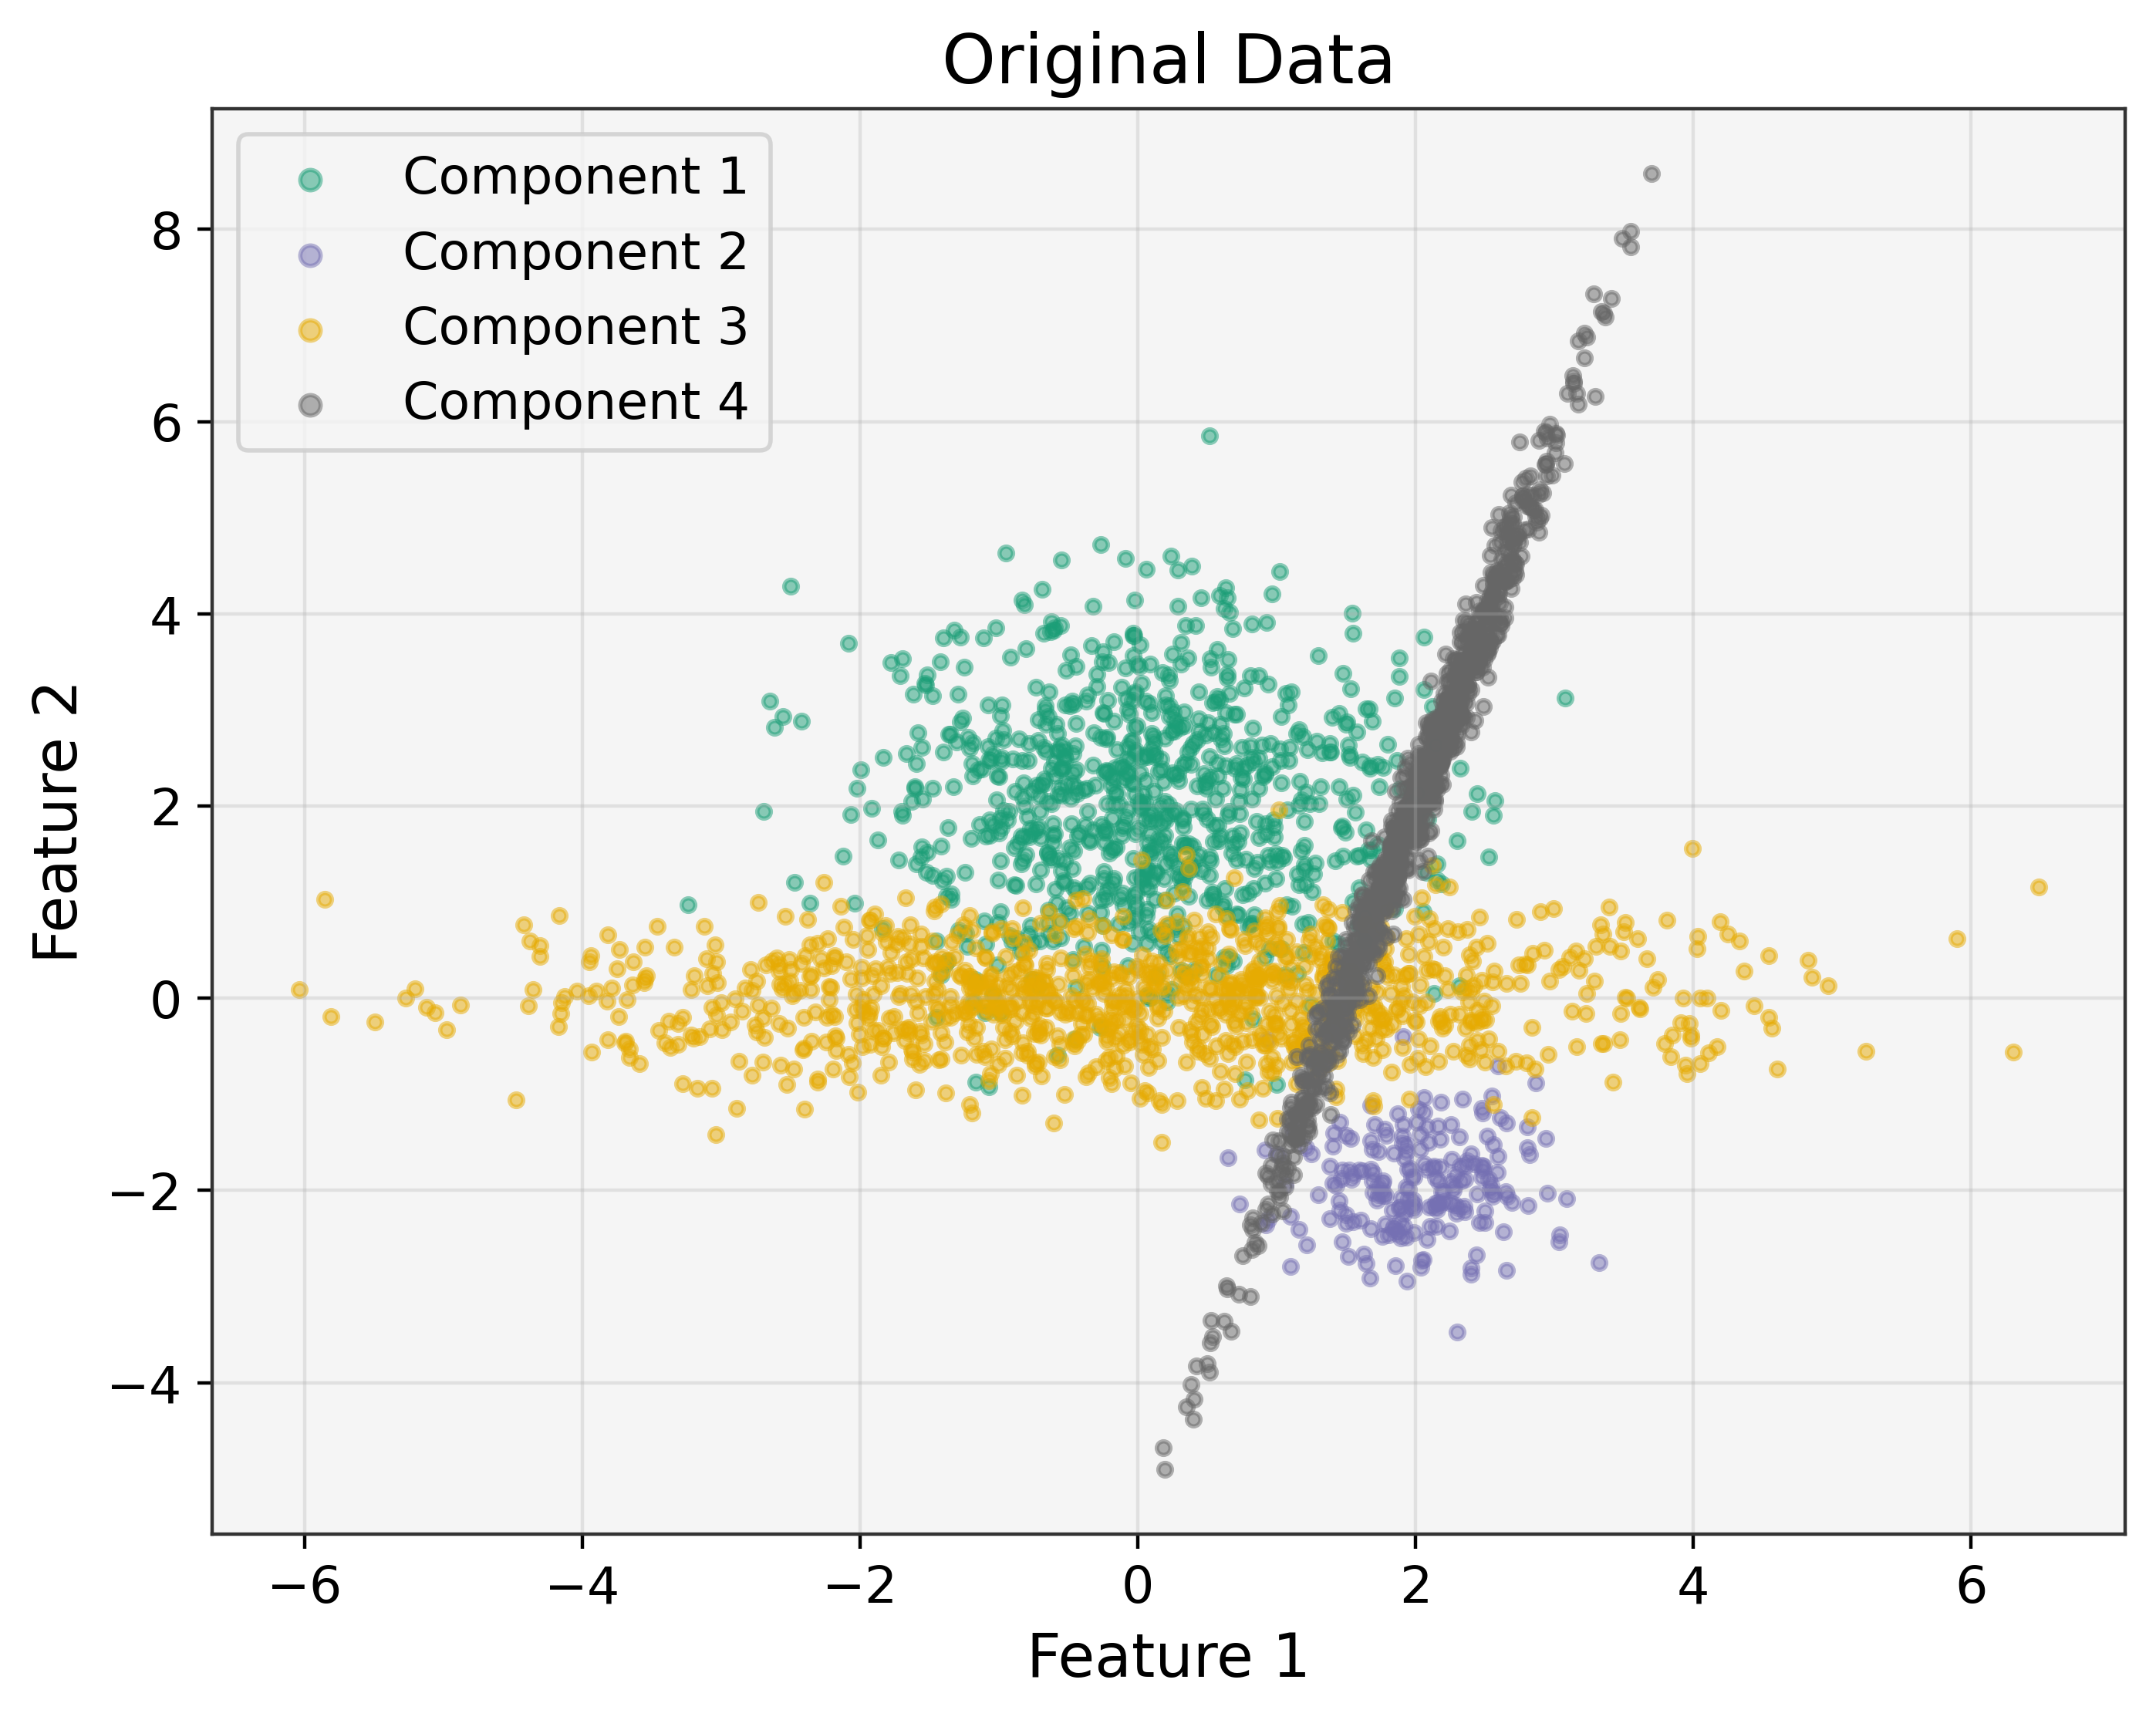

In [121]:
n_samples = [800, 200, 1000, 1000]
centers = [np.array([0, 2]),
           np.array([2, -2]),
           np.array([0, 0]),
           np.array([2, 2])]
covs = [
    1.0 * np.eye(2),                    # spherical covariance
    0.5 * np.eye(2),                    # spherical covariance, fewer points
    np.array([[2, 0], [0, 0.5]]),       # diagonal covariance
    np.array([[0.2, 0.5], [0.5, 2]])    # full covariance
]

components = []
for n, center, cov in zip(n_samples, centers, covs):
    samples = np.dot(np.random.randn(n, 2), cov) + center
    components.append(samples)

X = np.vstack(components)
labels = np.concatenate([i * np.ones(n) for i, n in enumerate(n_samples)])
legend_labels = [f'Component {i+1}' for i in range(len(n_samples))]

X_tensor = torch.tensor(X, dtype=torch.float32, device=device)

n_features = X.shape[1]
n_components = len(n_samples)

plot_gmm(X=X, labels=labels, title='Original Data', legend_labels=legend_labels)
plt.show()

In [125]:
import numpy as np
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# Define different alpha (concentration) vectors for 3 components
alpha_vectors = {
    "Uniform (α=1)": np.array([1, 1, 1]),
    "Sparse (α=0.1)": np.array([0.1, 0.1, 0.1]),
    "Concentrated (α=10)": np.array([10, 10, 10]),
    "Imbalanced (0.5, 1, 5)": np.array([0.5, 1, 5])
}

n_samples = 10000  # Number of samples to generate per setting

# Create a 2x2 subplot with each subplot being a ternary plot.
rows = 2
cols = 2
fig = make_subplots(
    rows=rows, 
    cols=cols,
    specs=[[{'type': 'ternary'} for _ in range(cols)] for _ in range(rows)],
    subplot_titles=list(alpha_vectors.keys())
)

i = 0
for title, alpha in alpha_vectors.items():
    # Sample from the Dirichlet distribution using the gamma sampling method.
    samples = np.random.gamma(shape=alpha, scale=1, size=(n_samples, 3))
    samples /= samples.sum(axis=1, keepdims=True)  # Normalize to make each sample sum to 1
    
    # Determine subplot position.
    row = i // cols + 1
    col = i % cols + 1
    
    # Create a ternary scatter trace.
    trace = go.Scatterternary(
        a = samples[:, 0],
        b = samples[:, 1],
        c = samples[:, 2],
        mode = 'markers',
        marker = dict(size=2, opacity=0.5),
        name = title
    )
    
    fig.add_trace(trace, row=row, col=col)
    i += 1

fig.update_layout(
    title="Samples from a Dirichlet Distribution (3 Components)",
    ternary = dict(
        sum = 1,
        aaxis = dict(title = "Component A"),
        baxis = dict(title = "Component B"),
        caxis = dict(title = "Component C")
    ),
    showlegend=False
)

fig.show()


## Impact of $\alpha$ in the Dirichlet Distribution and Visualization

In a Gaussian Mixture Model (GMM) with a Dirichlet prior on the mixture weights, the concentration parameter, often denoted as $\alpha$, plays a key role in shaping the prior distribution over the component weights.

### How $\alpha$ Affects the Dirichlet Distribution

- **Small $\alpha$ (e.g., $\alpha \ll 1$):**  
  When the concentration parameters are low, the Dirichlet distribution becomes *sparse*. In this regime, the prior favors solutions where most of the probability mass is concentrated on a few components, while the remaining components have weights close to zero. This can lead to more “hard” clustering where one or two clusters dominate.

- **$\alpha \approx 1$:**  
  When all concentration parameters are equal to 1, the Dirichlet distribution is uniform over the simplex. This means that, a priori, all weight configurations are equally likely, and the model is free to adjust the weights based entirely on the observed data.

- **Large $\alpha$ (e.g., $\alpha \ll 1$):**  
  High concentration parameters lead to a more concentrated (or “peaked”) Dirichlet distribution around the center of the simplex. In this case, the prior favors more balanced weights across components. The model is encouraged to assign roughly equal weight to each component, reducing variability in the mixing proportions.

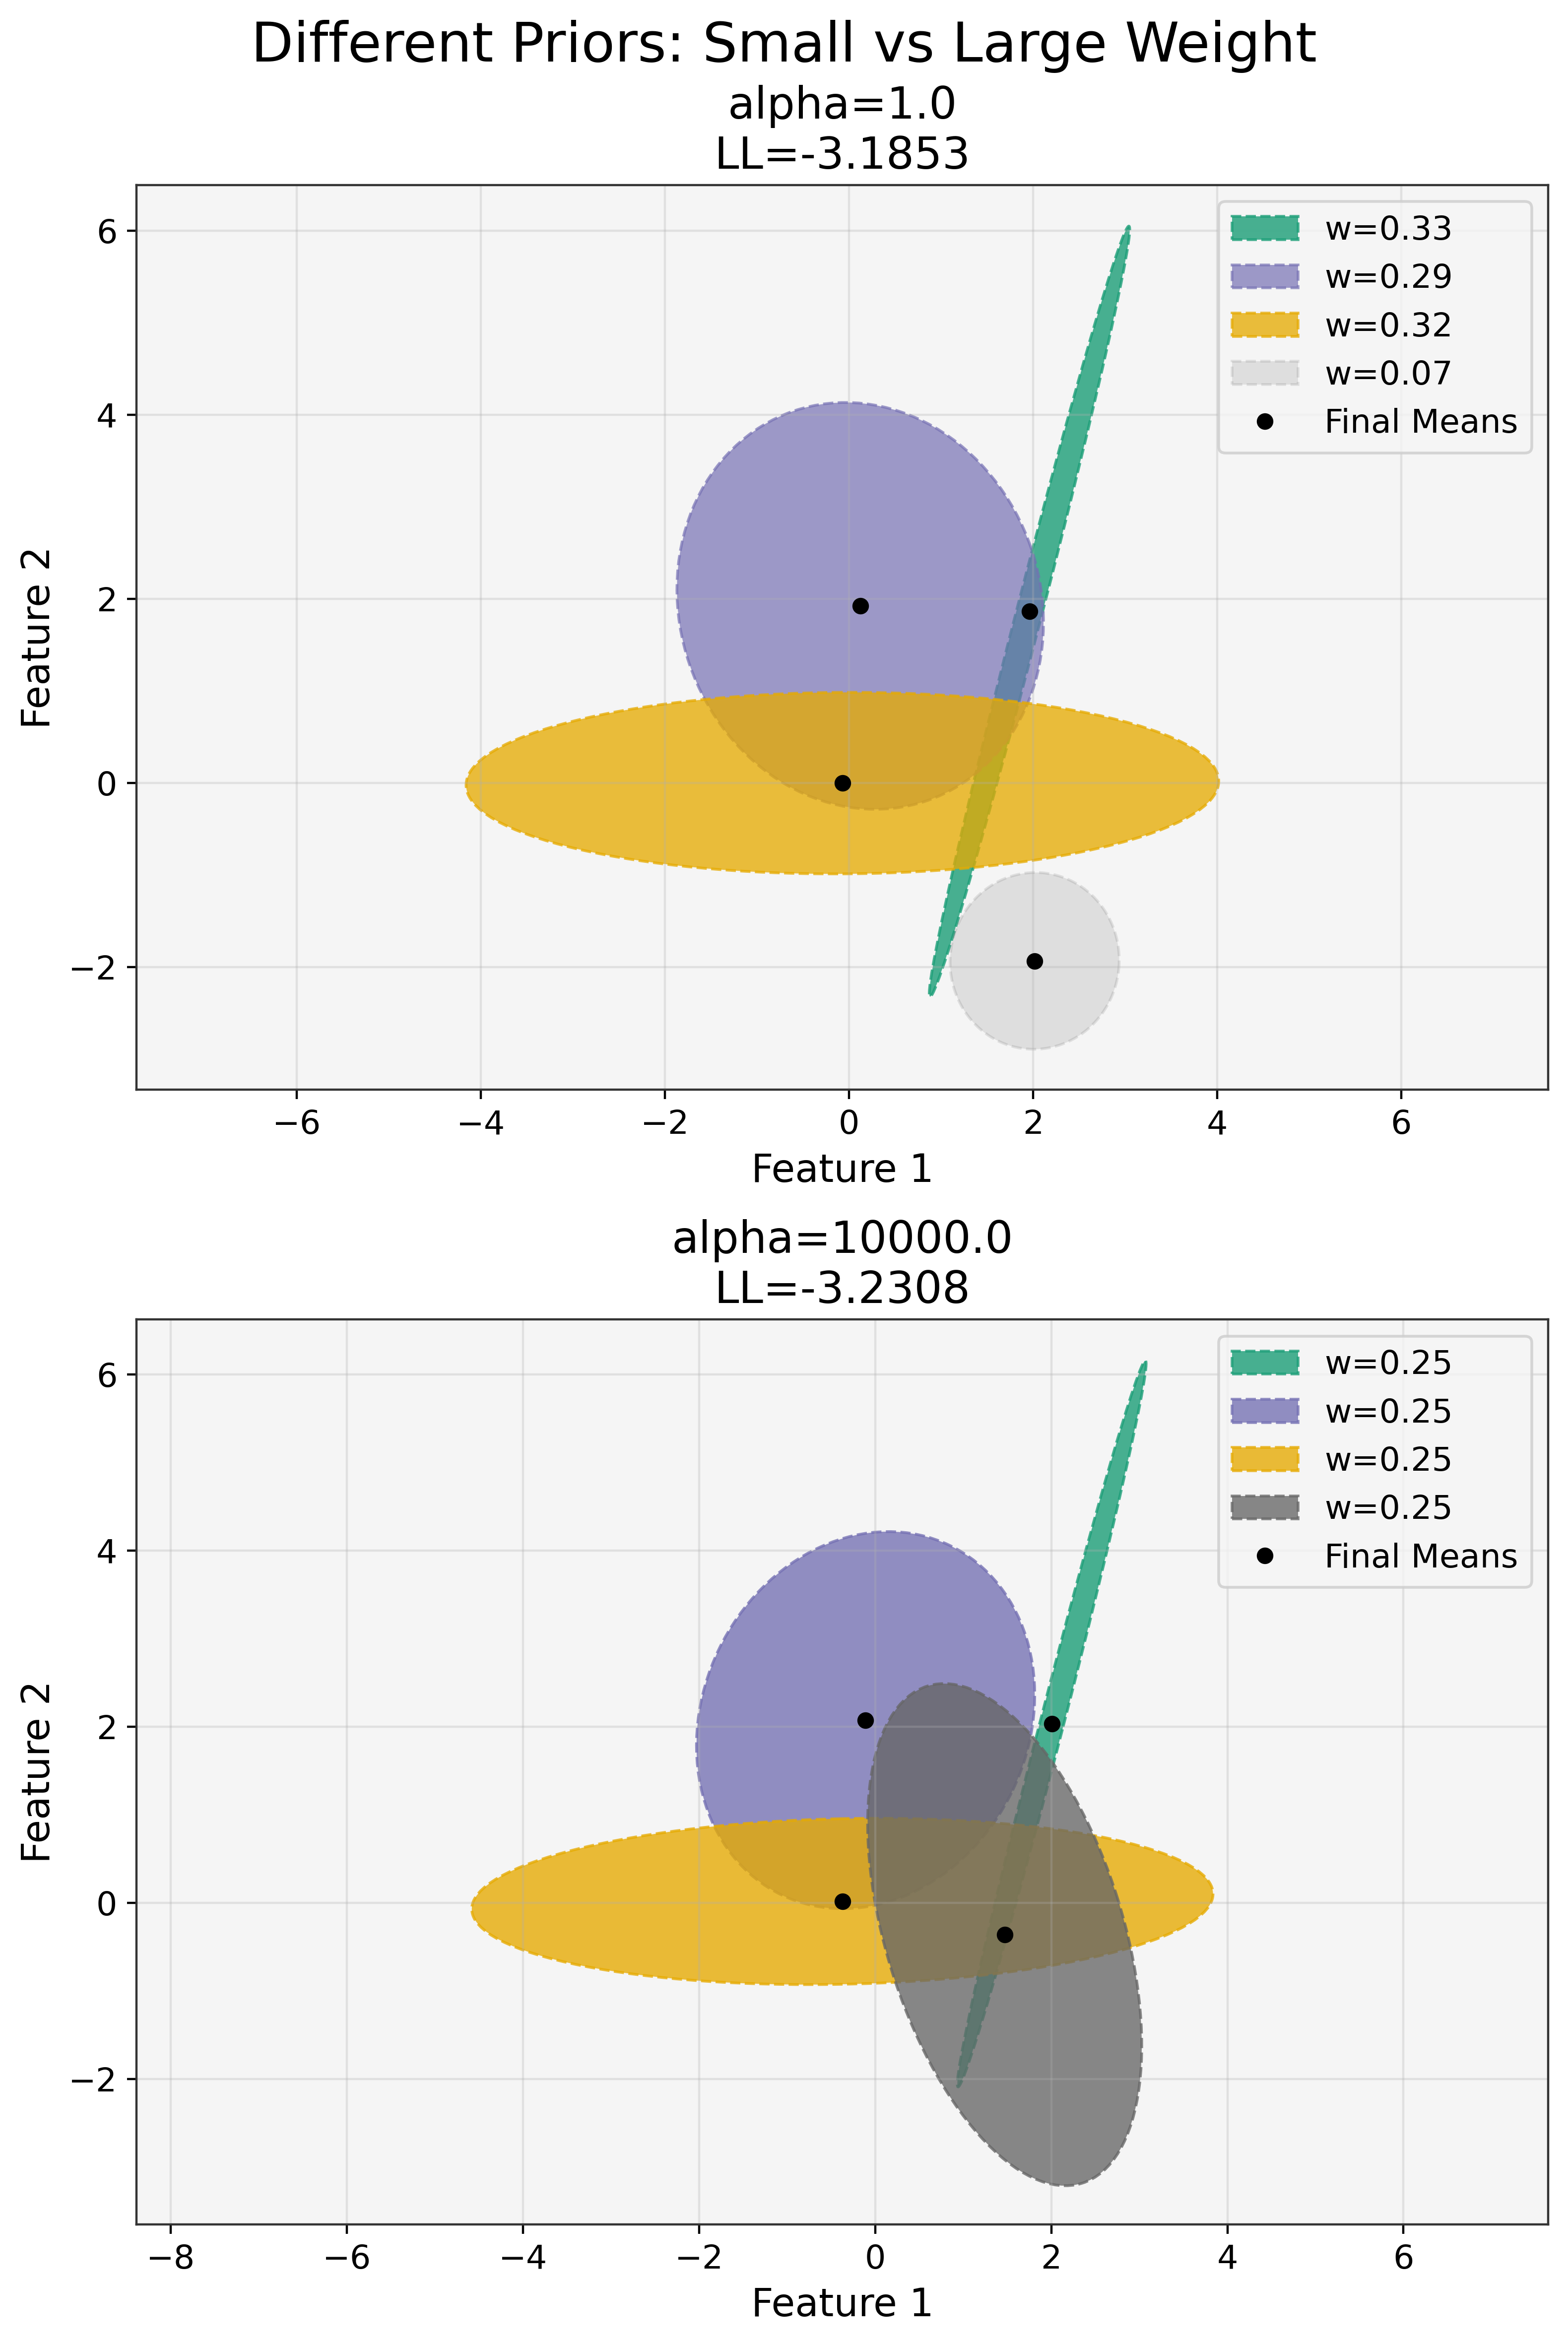

In [ ]:
weigths = np.array([1, 1e4])
weights = [torch.tensor([weight], device=device) for weight in weigths]

nrows, ncols = 2, 1
figsize = dynamic_figsize(nrows, ncols)
fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=figsize)
fig.suptitle("Different Priors: Small vs Large Weight")

colors = ['red', 'blue', 'green', 'purple']

for ax, weight in zip(axs, weigths):
    gmm_weight_prior = GaussianMixture(
        n_features=n_features,
        n_components=n_components,
        covariance_type='full',
        max_iter=1000,
        device=device,
        weight_concentration_prior=weight,
        random_state=random_state,
        init_params='random'
    )
    gmm_weight_prior.fit(X_tensor)
    # Plot only ellipses and means, with alpha based on component weights.
    plot_gmm(X=None, gmm=gmm_weight_prior, ax=ax,
             title=f"alpha={weight.item()}\nLL={gmm_weight_prior.lower_bound_:.4f}",
             alpha_from_weight=True,
             dashed_outer=True,
             base_alpha=0.8)
    ax.axis('equal')
    ax.legend(loc='upper right')

plt.tight_layout()
plt.show()


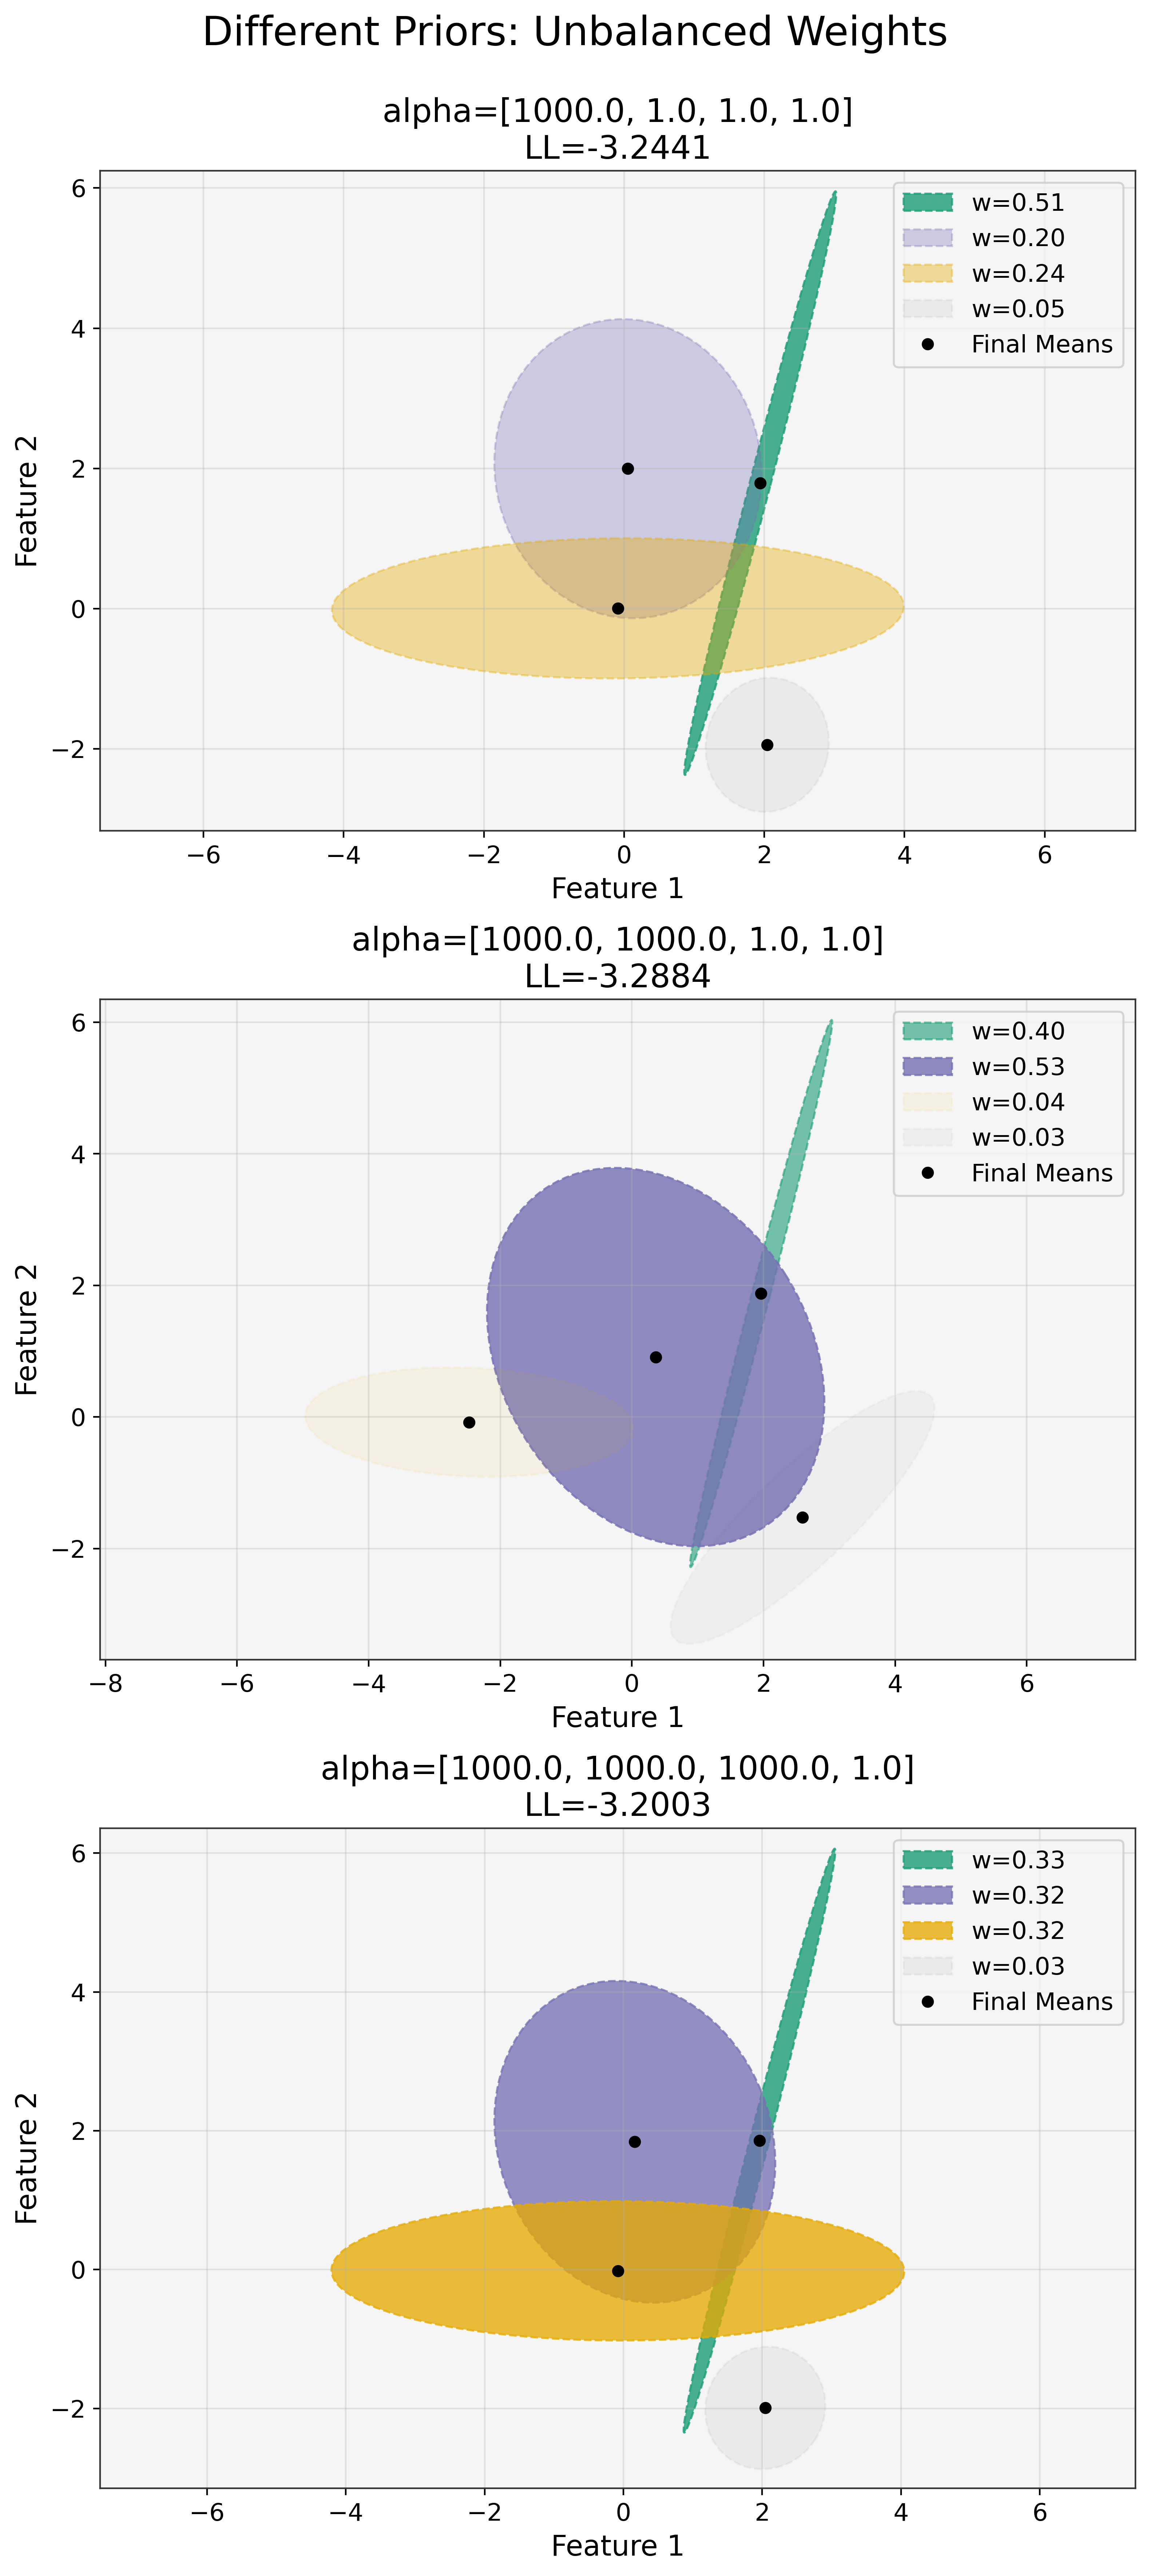

In [ ]:
# Example: One dominant prior and three nearly zero priors.
# Here, we expect the first component to dominate.
weight1 = torch.tensor([1000.0, 1, 1, 1], device=device)
weight2 = torch.tensor([1000.0, 1000.0, 1, 1], device=device)
weight3 = torch.tensor([1000.0, 1000.0, 1000.0, 1], device=device)
weights = [weight1, weight2, weight3]

nrows, ncols = len(weights), 1
figsize = dynamic_figsize(nrows, ncols)
fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=figsize)
fig.suptitle("Different Priors: Unbalanced Weights")

for ax, weight in zip(axs, weights):
    gmm_weight_prior = GaussianMixture(
        n_features=n_features,
        n_components=n_components,
        covariance_type='full',
        max_iter=1000,
        device=device,
        weight_concentration_prior=weight,
        random_state=random_state,
        init_params='random'
    )
    gmm_weight_prior.fit(X_tensor)
    # Plot only ellipses and means, with alpha based on component weights.
    plot_gmm(X=None, gmm=gmm_weight_prior, ax=ax,
             title=f"alpha={weight.tolist()}\nLL={gmm_weight_prior.lower_bound_:.4f}",
             alpha_from_weight=True,
             dashed_outer=True,
             base_alpha=0.8)
    ax.axis('equal')
    ax.legend(loc='upper right')

ax.axis('equal')
ax.legend(loc='upper right')
plt.tight_layout(rect=[0, 0, 1, 0.98])
plt.show()


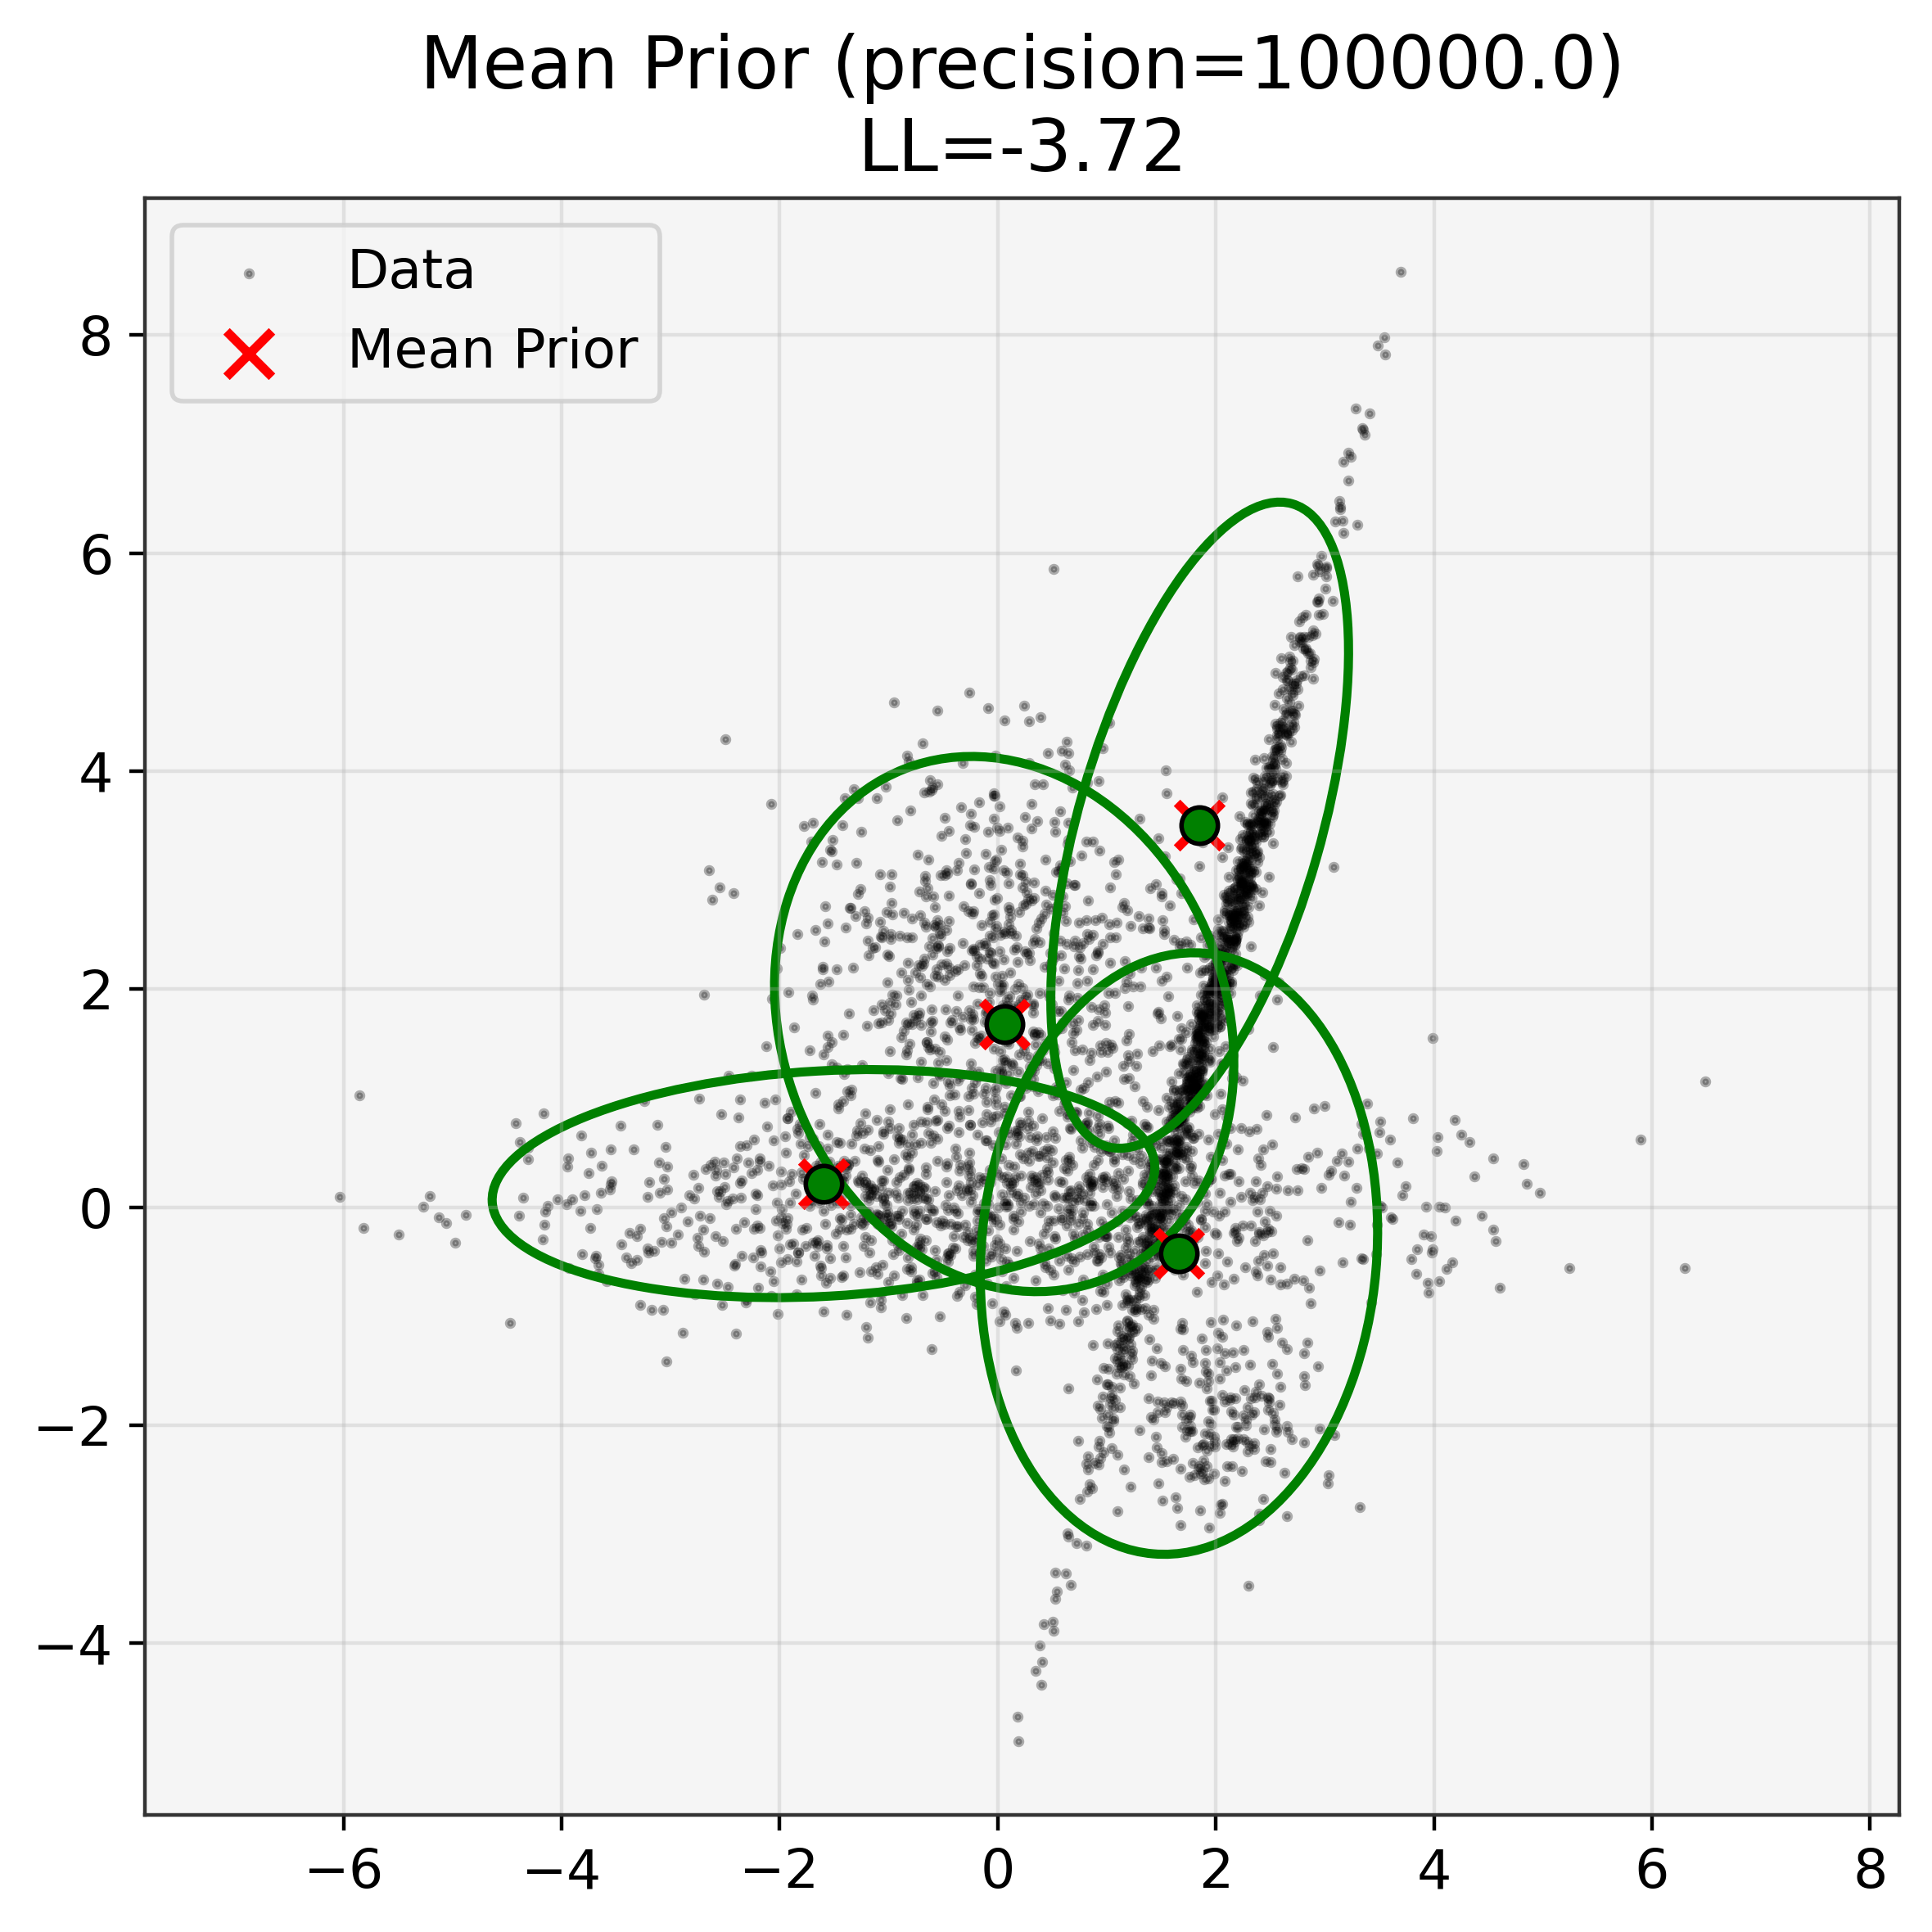

In [ ]:
init_means_kmeans = GMMInitializer.kmeans(X_tensor.cpu(), k=n_components)  # do on CPU
mean_prior = init_means_kmeans.clone().to(device)
mean_precision_prior = 1e5  # large => strong push toward prior means

# perturb the prior means slightly
mean_prior += 0.5 * torch.randn_like(mean_prior)

gmm_mean_prior = GaussianMixture(
    n_features=n_features,
    n_components=n_components,
    covariance_type='full',
    max_iter=1000,
    device=device,
    mean_prior=mean_prior,
    mean_precision_prior=mean_precision_prior,
    random_state=random_state
)
gmm_mean_prior.fit(X_tensor)

fig, ax = plt.subplots(1, 1, figsize=(6, 6))
title = f"Mean Prior (precision={mean_precision_prior})\nLL={gmm_mean_prior.lower_bound_:.2f}"
plot_gmm_ellipses(gmm_mean_prior, X_tensor, ax=ax, title=title, color='green')

# Plot the prior means as red crosses
ax.scatter(mean_prior[:, 0].cpu(), mean_prior[:, 1].cpu(), marker='x', s=100, c='red', label='Mean Prior')
ax.legend()
plt.tight_layout()
plt.show()


NameError: name 'max_iter' is not defined

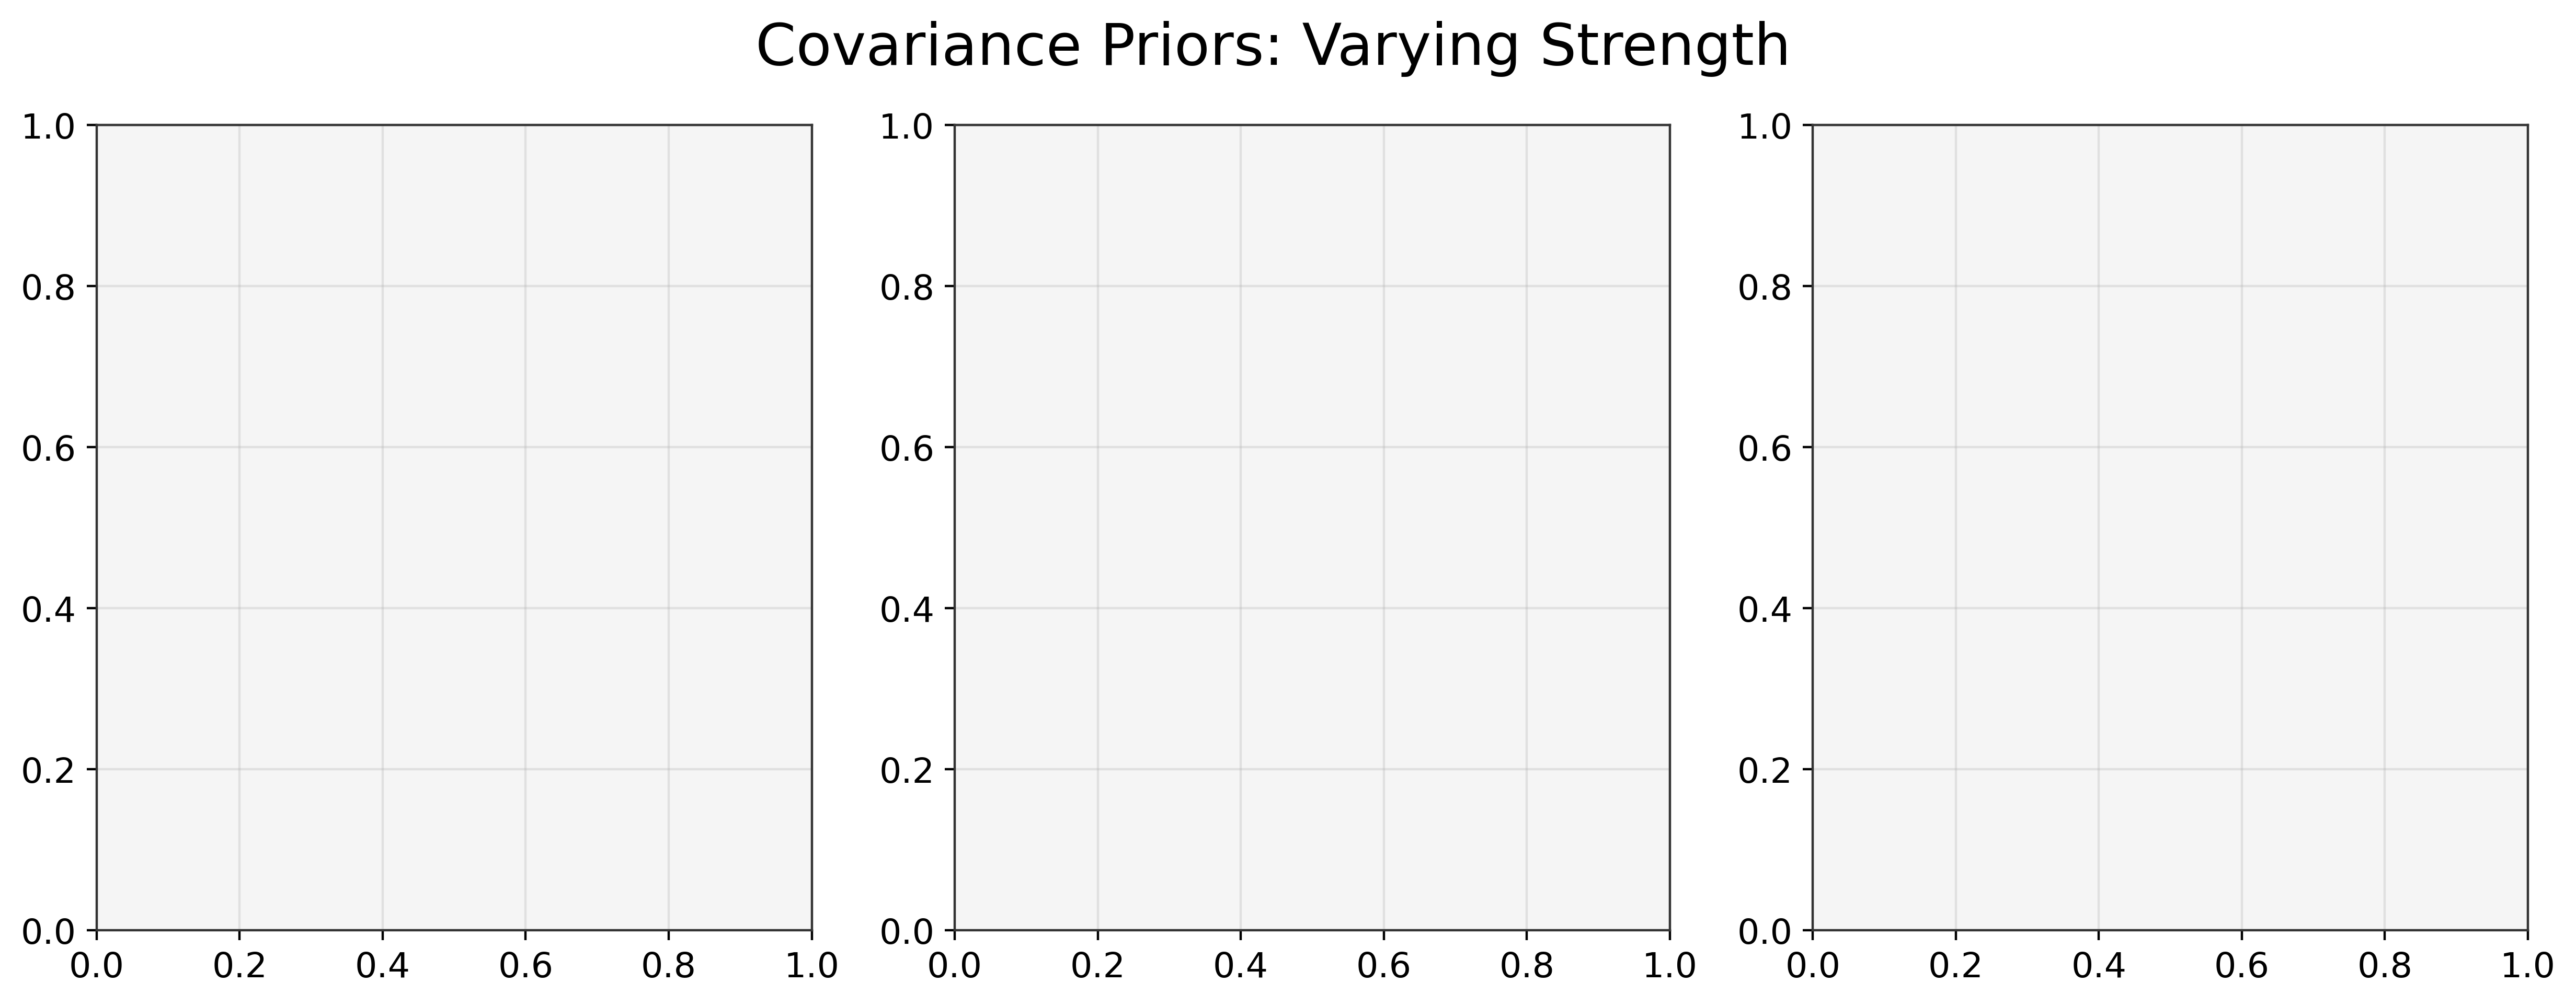

In [ ]:
data_covariance = np.cov(X_tensor.cpu().numpy(), rowvar=False)  # shape (2, 2)
data_covariance = torch.tensor(data_covariance, dtype=torch.float32, device=device)
data_covariance = data_covariance.unsqueeze(0).expand(n_components, -1, -1)

degrees_of_freedom_prior = float(n_features + 2)
prior_strengths = [0.01, 0.1, 1.0]

fig, axs = plt.subplots(1, 3, figsize=(15, 5))
fig.suptitle("Covariance Priors: Varying Strength")

for ax, strength in zip(axs, prior_strengths):
    cov_prior = data_covariance * strength

    dummy_mean_prior = torch.zeros(n_components, n_features, device=device)
    dummy_mean_precision_prior = 1e-10  # effectively no strong push on means

    gmm_cov_prior = GaussianMixture(
        n_features=n_features,
        n_components=n_components,
        covariance_type='full',
        max_iter=max_iter,
        device=device,
        # Covariance prior:
        covariance_prior=cov_prior,  
        degrees_of_freedom_prior=degrees_of_freedom_prior,
        # Provide "dummy" mean priors so code doesn't crash
        mean_prior=dummy_mean_prior,
        mean_precision_prior=dummy_mean_precision_prior
    )
    gmm_cov_prior.fit(X_tensor)


    title = (f"CovPrior Strength={strength}\n"
             f"dof={degrees_of_freedom_prior}\nLogLik={gmm_cov_prior.lower_bound_:.2f}")
    plot_gmm_ellipses(gmm_cov_prior, X_tensor, ax=ax, title=title, color='magenta')

plt.tight_layout()
plt.show()

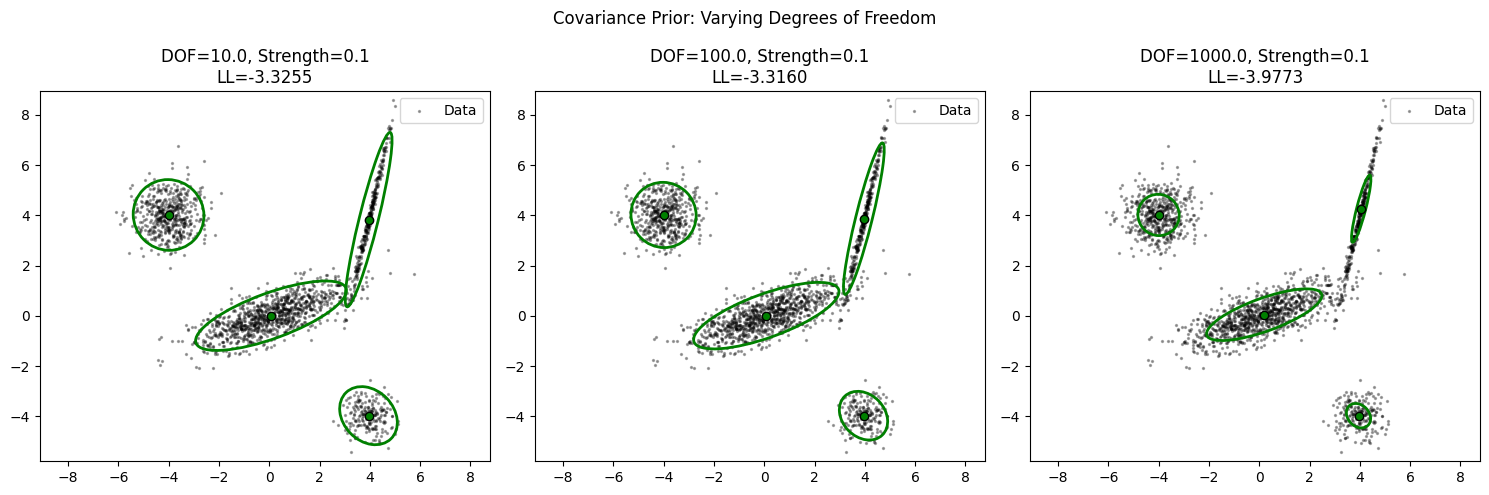

In [ ]:
dof_values = [10.0, 100.0, 1000.0]  # must be > n_features - 1 => > 1 for 2D
strength = 0.1  # fixed prior strength for demonstration

fig, axs = plt.subplots(1, 3, figsize=(15, 5))
fig.suptitle("Covariance Prior: Varying Degrees of Freedom")

for ax, dof in zip(axs, dof_values):
    cov_prior = data_covariance * strength

    # Example to skip MAP on means by making them "neutral"
    dummy_mean_prior = torch.zeros(n_components, n_features, device=device)
    dummy_mean_precision_prior = 1e-10  # effectively no strong push on means

    gmm_cov_prior = GaussianMixture(
        n_features=n_features,
        n_components=n_components,
        covariance_type='full',
        max_iter=max_iter,
        device=device,
        # Covariance prior:
        covariance_prior=cov_prior,  
        degrees_of_freedom_prior=dof,
        # Provide "dummy" mean priors so code doesn't crash
        mean_prior=dummy_mean_prior,
        mean_precision_prior=dummy_mean_precision_prior,
        random_state=random_state
    )
    gmm_cov_prior.fit(X_tensor)


    title = (f"DOF={dof}, Strength={strength}\n"
             f"LL={gmm_cov_prior.lower_bound_:.4f}")
    plot_gmm_ellipses(gmm_cov_prior, X_tensor, ax=ax, title=title, color='green')

plt.tight_layout()
plt.show()